In [1]:
######################################################### Settings #########################################################
from qutip import *
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import get_cmap
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
    'text.usetex': True,              # Enable LaTeX for text rendering
    'font.family': 'serif',           # Use a serif font family
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Latex\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)


fixed_lam = 1
fixed_gamma = 1
fixed_dist_ext = fixed_lam
fixed_dist_in = fixed_dist_ext
#  I am in the symmetric case

######################################################### Functions #########################################################
def dipole_vector(phi):
    return np.array([np.cos(phi), np.sin(phi), 0])


def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])


def chain_positions(distance, N_atoms = 3):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions_all_inner(distance_in = fixed_dist_in, N_atoms = 3):
    Pos = np.zeros((N_atoms, 3))
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(fixed_dist_ext, N_atoms // 3) + [r, 0, 0]
    Pos[:N_atoms//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N_atoms//3:2*N_atoms//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N_atoms//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    return Pos

def topo_positions_only_1_inner(distance_in = fixed_dist_in, N_atoms = 3):
    if distance_in >= 2 * fixed_dist_ext:
        distance_in = 2 * fixed_dist_ext - 1e-5
    Pos = np.zeros((N_atoms, 3))
    N_chain = N_atoms // 3
    height = np.sqrt(fixed_dist_ext ** 2 - (distance_in / 2) ** 2)
    r_in = (2 * fixed_dist_ext * distance_in - distance_in ** 2) / (4 * height)
    MB = np.sqrt(r_in ** 2 + (distance_in / 2) ** 2)
    angle = np.arccos(((r_in) / MB))
    A = np.array([height - r_in, 0, 0])
    B = np.array([r_in, distance_in / 2, 0])
    C = np.array([r_in, -distance_in / 2, 0])
    Chain = chain_positions(fixed_dist_ext, N_chain)
    Pos[:N_chain] = np.dot(Chain + A, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N_chain:2 * N_chain] = np.dot(Chain, z_rotation(angle).T) + B
    Pos[2 * N_chain:] = np.dot(Chain, z_rotation(-angle).T) + C
    return Pos

def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
            * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
               + (- kappa ** 2 - 3 * 1j * kappa + 3)
               * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, dipoles, N_atoms):
    positions = topo_positions_all_inner(distance_in, N_atoms)
    G_matrix = np.zeros((N_atoms, N_atoms), dtype=complex)
    for a in range(N_atoms):
        for b in range(N_atoms):
            r_a, r_b = positions[a], positions[b]
            G_matrix[a, b] = fixed_gamma
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / fixed_lam
                G_matrix[a, b] = np.imag((6 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(
                    Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, dipoles, N_atoms):
    positions = topo_positions_all_inner(distance_in, N_atoms)
    V_matrix = np.zeros((N_atoms, N_atoms), dtype=complex)
    for a in range(N_atoms):
        for b in range(N_atoms):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / fixed_lam
                V_matrix[a, b] = - np.real((3 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(
                    Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix

def Hamilton(distance_in, angle, N_atoms):
    dipoles = [dipole_vector(angle) for _ in range(N_atoms)]
    G = Gamma_matrix(distance_in, dipoles, N_atoms)
    V = V_matrix(distance_in, dipoles, N_atoms)
    # Generate connections based on the updated rules
    '''
    connections = {}
    for i in range(N_atoms):
        connections[i] = [i]
        if i - 1 >= 0:
            connections[i].append(i - 1)
        if i + 1 < N_atoms:
            connections[i].append(i + 1)        
        if i == N_atoms // 3 - 1:
            connections[i].append(2 * N_atoms // 3)
        elif i == N_atoms // 3:
            connections[i].append(2 * N_atoms // 3)
        elif i == 2 * N_atoms // 3:
            if i - 1 in connections[i]:
                connections[i].remove(i - 1)
            connections[i].extend([N_atoms // 3, N_atoms // 3 - 1])
        connections[i] = sorted(list(set(connections[i])))
    # create a almost NN interaction behavior
    #    for i in range(N_atoms):
    #        for j in range(N_atoms):
    #            if j not in connections[i]:
    #                x = 0
    #                G[i, j] = 0
    #                V[i, j] = 0
    '''
    H = Qobj(V) - 1j / 2 * Qobj(G)
    
    idx1 = N_atoms // 3 - 1    # Extract relevant indices
    idx2 = N_atoms // 3
    idx3 = 2 * N_atoms // 3
        
    phi1 = np.angle(H[idx1, idx2])     # Calculate phases
    phi2 = np.angle(H[idx2, idx3])
    phi3 = np.angle(H[idx3, idx1])
    
    return H, phi1, phi2, phi3     # Return Hamiltonian and the sum of phases

def create_wave_packet(N_atoms, indx):
    return Qobj(basis(N_atoms, indx))
#    k_s = np.pi / fixed_dist_ext
#    sigma = 0.1 * k_s
#    center_index = N_atoms // 6
#    x_j = (np.arange(N_atoms // 3) - center_index) * fixed_dist_ext
#    coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma ** 2 * x_j ** 2)
#    wave_packet = sum(coeff * basis(N_atoms, arm * N_atoms//3 + j) for j, coeff in enumerate(coefficients))
#   return wave_packet.unit()

def own_wave_packet(N_atoms):
    # Parameters
    k_s = np.pi / fixed_dist_ext
    sigma_k = 0.1 * k_s
    center_index = N_atoms // 6
    
    # Define p(k) based on k
    def p(k):
        return 2 * np.pi * k / (N_atoms * fixed_dist_ext)
    
    # Initialize the wavepacket as a zero vector
    wave_packet = basis(N_atoms, 0) * 0  # Zero vector initialization

    # Construct the wave_packet using the Gaussian in momentum space with p(k)
    for i in range(N_atoms//3):
        state = basis(N_atoms, i)
        weight = np.exp(-1j * p(k_s) * fixed_dist_ext * (i - center_index)) * \
                 np.exp(-(i - center_index)**2 * fixed_dist_ext**2 / (2 * sigma_k**2))
        wave_packet += weight * state  # Use += instead of =+
    
    wave_packet = wave_packet.unit()
    return wave_packet.tidyup()

def survival_probabilities(times, dipoles, distance_in, Psi_0, N_atoms):
    H = Hamilton(distance_in, dipoles, N_atoms)
    coeffs_sq_mods = np.zeros((len(times), N_atoms))
    P_surs = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t) ** 2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

def P_if(t, distance_in, angle, Psi_0, Psi_f, N_atoms):
    H, phi1, phi2, phi3 = Hamilton(distance_in, angle, N_atoms)
    Theta = phi1 + phi2 + phi3
    U = (-1j * H * t).expm()
    Psi_t = U * Psi_0
    P = (Psi_f.dag() * Psi_t)


    return P, Theta

# FAST CALCULATIONS using parallel processing!
# Function to calculate probabilities for a given combination of angle and distance
def calculate_probabilities(i, j):
    distance_in = distances[i]
    angle = angles[j]
    P_u_vals = np.zeros(len(times))
    P_d_vals = np.zeros(len(times))
    Theta = None
    for a, t in enumerate(times):
        # Probability of being in Psi_u & Psi_d
        P_u, Theta = P_if(t, distance_in, angle, Psi_0, Psi_u, N_atoms)
        P_d, Theta = P_if(t, distance_in, angle, Psi_0, Psi_d, N_atoms)
        P_u_vals[a], P_d_vals[a] = np.abs(P_u) ** 2, np.abs(P_d) ** 2
    # Return a structured result containing distance, angle, Theta, P_u and P_d values
    return {
        'distance': distance_in,
        'angle': angle,
        'Theta': Theta % (2 * np.pi),
        'P_u_vals': P_u_vals,
        'P_d_vals': P_d_vals
    }

In [2]:
# Define your function
def calculate_Theta(i, j):
    distance_in = distances[i]
    angle = angles[j]
    H, phi1, phi2, phi3 = Hamilton(distance_in, angle, N_atoms)
    Theta = phi1 + phi2 + phi3
    return Theta % (2 * np.pi)

# Parameters
N_atoms = 3
fixed_dist_ext = 0.234
num_angle_points = 500
num_distance_points = 500
angles = np.linspace(0, 1*np.pi/3, num_angle_points)
distances = np.linspace(fixed_dist_ext/10, fixed_dist_ext*2, num_distance_points)
Theta_values = Parallel(n_jobs=-1)(delayed(calculate_Theta)(i, j) for i in range(num_distance_points) for j in range(num_angle_points))
Theta_values = np.array(Theta_values).reshape(num_distance_points, num_angle_points)

# Find min and max Theta values
min_value = Theta_values.min()
max_value = Theta_values.max()

# Create a color plot for Theta vs Distance and Angle (switched axes)
fig, ax = plt.subplots()
c = ax.pcolormesh(distances, angles, Theta_values.T, shading='auto', cmap='coolwarm')
# Add contour lines on top of the color plot
contour_levels = np.linspace(Theta_values.min(), Theta_values.max(), 10)  # Define contour levels
contour = ax.contour(distances, angles, Theta_values.T, levels=contour_levels, colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour, inline=True, fontsize=8, fmt={level: f'{level:.2f}' for level in contour_levels})
# Set labels for distance and angle, showing angles as multiples of π
ax.set_xlabel(r'$d / \lambda$')
ax.set_ylabel(r'$\phi$ (in multiples of $\pi$)')
ax.set_yticks([0, np.pi/6, np.pi/3])
ax.set_yticklabels([r'$0$', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$'])

# Add a colorbar and adjust ticks for Theta
cbar = fig.colorbar(c, ax=ax, label=r'$\theta$')
cbar.set_ticks([min_value, max_value/4, max_value/3, max_value/2, max_value])
cbar.set_ticklabels(['0', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$2\pi$'])

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
figure_name = f"THETA(d,phi)_for_symm_system.svg"
#plt.savefig(os.path.join(output_dir, figure_name))

plt.show()

KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

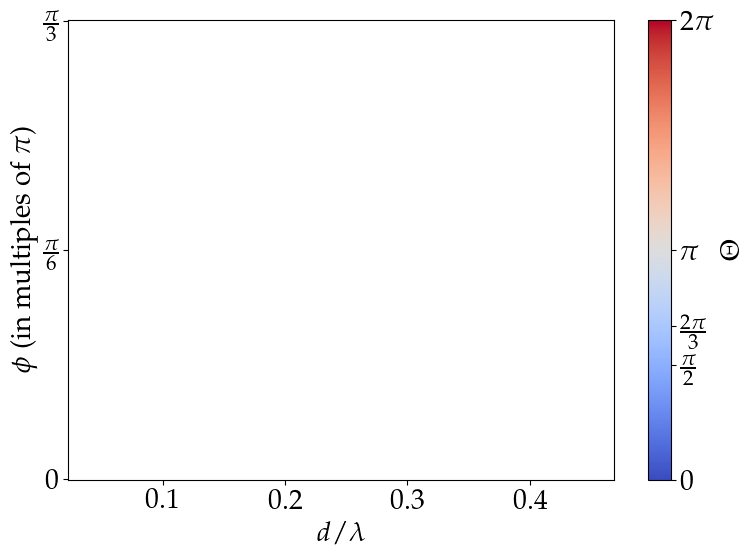

In [3]:
#
# Plot data and axes seperate to make the bearbeitung easier
#
# Define your function
def calculate_Theta(i, j):
    distance_in = distances[i]
    angle = angles[j]
    H, phi1, phi2, phi3 = Hamilton(distance_in, angle, N_atoms)  # Assuming Hamilton is defined elsewhere
    Theta = phi1 + phi2 + phi3
    return Theta % (2 * np.pi)

# Parameters
N_atoms = 3
fixed_dist_ext = 0.234
num_angle_points = 500
num_distance_points = 500
angles = np.linspace(0, 1*np.pi/3, num_angle_points)
distances = np.linspace(fixed_dist_ext/10, fixed_dist_ext*2, num_distance_points)
Theta_values = Parallel(n_jobs=-1)(delayed(calculate_Theta)(i, j) for i in range(num_distance_points) for j in range(num_angle_points))
Theta_values = np.array(Theta_values).reshape(num_distance_points, num_angle_points)

# Find min and max Theta values
min_value = Theta_values.min()
max_value = Theta_values.max()

# Step 1: Plot only the data (as a PNG without axes and labels)
fig_data, ax_data = plt.subplots()

# Plot the pcolormesh with Theta values (data only)
c = ax_data.pcolormesh(distances, angles, Theta_values.T, shading='auto', cmap='coolwarm')

# Remove axes and labels
ax_data.axis('off')

# Save only the data as a PNG
data_filename = os.path.join(output_dir, "Theta_Data_Only.png")
fig_data.savefig(data_filename, bbox_inches='tight', pad_inches=0, format='png')

# Clear the figure
plt.clf()

# Step 2: Plot the axes, colormaps, and labels (as an SVG)
fig_axes, ax_axes = plt.subplots()

# Re-plot the pcolormesh to get the colormap, but hide it in the output
c = ax_axes.pcolormesh(distances, angles, Theta_values.T, shading='auto', cmap='coolwarm')

# Add a colorbar
cbar = fig_axes.colorbar(c, ax=ax_axes, label=r'$\Theta$')

# Set labels for distance and angle
ax_axes.set_xlabel(r'$d / \lambda$')
ax_axes.set_ylabel(r'$\phi$ (in multiples of $\pi$)')

# Customize ticks
ax_axes.set_yticks([0, np.pi/6, np.pi/3])
ax_axes.set_yticklabels([r'$0$', r'$\frac{\pi}{6}$', r'$\frac{\pi}{3}$'])

# Set limits and label for the colorbar
cbar.set_ticks([min_value, max_value/4, max_value/3, max_value/2, max_value])
cbar.set_ticklabels([r'0', r'$\frac{\pi}{2}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$2\pi$'])

# Hide the pcolormesh but keep the axes and labels
c.set_visible(False)

# Save the figure with only axes, labels, and colormap as an SVG
axes_filename = os.path.join(output_dir, "Theta_Axes_Only.svg")
fig_axes.savefig(axes_filename, format='svg', bbox_inches='tight')

# Show the final figure (optional)
plt.show()

In [87]:
from collections import defaultdict

# Set a tolerance for grouping the same Theta values (use radians)
tolerance = 1e-8

# Dictionary to store the combinations
theta_combinations = defaultdict(list)

# Group combinations by Theta values
for i in range(num_distance_points):
    for j in range(num_angle_points):
        theta = Theta_values[i, j]
        rounded_theta = round(theta / tolerance) * tolerance  # Round to nearest tolerance
        theta_combinations[rounded_theta].append((distances[i], angles[j]))

# Display the results
for theta, combinations in theta_combinations.items():
    print(f"Theta = {theta:.3f} radians:")
    for dist, angle in combinations:
        print(f"  Distance: {dist}, Angle: {angle}")
    print()  # Add space between groups

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Assuming these functions are defined somewhere in your code
# They should calculate wave packets and probabilities
# Parameters
N_atoms = 6
Psi_0 = create_wave_packet(N_atoms, 0)
Psi_u = create_wave_packet(N_atoms, 3)
Psi_d = create_wave_packet(N_atoms, 5)


# Combinations of (distance, angle)
comb1 = {'distance': 0.07240400801603207, 'angle': 0.3777466116540833}
comb2 = {'distance': 0.07240400801603207, 'angle': 0.6694509395425143}

# Find the indices of these combinations in the distances and angles arrays
i1 = np.abs(distances - comb1['distance']).argmin()
j1 = np.abs(angles - comb1['angle']).argmin()
print(i1,j1)
i2 = np.abs(distances - comb2['distance']).argmin()
j2 = np.abs(angles - comb2['angle']).argmin()
print(i2,j2)
times = np.linspace(0, 10, 1000)
# Calculate probabilities for the two combinations
result1 = calculate_probabilities(i1, j1)
result2 = calculate_probabilities(i2, j2)

# Extract results for plotting
distance1, distance2 = result1['distance'], result2['distance']
angle1, angle2 = result1['angle'], result2['angle']
Theta1, Theta2 = result1['Theta'], result2['Theta']
P_u_vals1, P_u_vals2 = result1['P_u_vals'], result2['P_u_vals']
P_d_vals1, P_d_vals2 = result1['P_d_vals'], result2['P_d_vals']

# Create 2 plots: one for P_u, one for P_d
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Plot P_u values
ax1.set_title(r'$\theta_1={:.2f} \text{{ and }} \theta_2={:.2f}$'.format(Theta1, Theta2))
ax1.plot(times, P_u_vals1, label=f'$\phi={angle1:.2f}$, $d/\\lambda={distance1:.2f}$')
ax1.plot(times, P_u_vals2, label=f'$\phi={angle2:.2f}$, $d/\\lambda={distance2:.2f}$')
ax1.set_ylabel('$P_u$')
ax1.legend(loc='upper right')

# Plot P_d values
ax2.plot(times, P_d_vals1)#, label=f'$\\theta={Theta1:.2f}$: $\phi={angle1:.2f}$, $d/\\lambda={distance1:.2f}$')
ax2.plot(times, P_d_vals2)#, label=f'$\\theta={Theta2:.2f}$: $\phi={angle2:.2f}$, $d/\\lambda={distance2:.2f}$')
#ax2.legend(loc='best')
ax2.set_xlabel(r'$\gamma t$')
ax2.set_ylabel('$P_d$')

#ax3.plot(times, P_u_vals1)#, label=f'$\phi={angle1:.2f}$, $d/\\lambda={distance1:.2f}$')
#ax3.plot(times, P_u_vals2)
#ax3.plot(times, P_d_vals1)#, label=f'$\\theta={Theta1:.2f}$: $\phi={angle1:.2f}$, $d/\\lambda={distance1:.2f}$')
#ax3.plot(times, P_d_vals2)#, label=f'$\\theta={Theta2:.2f}$: $\phi={angle2:.2f}$, $d/\\lambda={distance2:.2f}$')
#ax2.legend(loc='best')
#ax3.set_xlabel(r'$\gamma t$')
#ax3.set_ylabel('$P_{both}$')
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [115]:
# Create a single plot for P_d values
fig, ax2 = plt.subplots(figsize=(6, 4))

# Plot P_d values
ax2.set_title(r'$\theta_={:.2f}$: $d={:.2f}\lambda$'.format(Theta1, distance2))
ax2.plot(times, P_d_vals1, label=f'$\phi_1={angle1:.5f}$')
ax2.plot(times, P_d_vals2, label=f'$\phi_2=\phi_1+\pi/6$')

# Set x-axis and y-axis ticks for min and max values
ax2.set_xlim(times.min(), times.max())
# Set y-axis limits (range) to the min and max across both P_d_vals1 and P_d_vals2
ax2.set_ylim(min(P_d_vals1.min(), P_d_vals2.min()), max(P_d_vals1.max(), P_d_vals2.max()))
ax2.set_xticks([times.min(), times.max()/4, times.max()/2, times.max()])
ax2.set_yticks([min(P_d_vals1.min(), P_d_vals2.min()), max(P_d_vals1.max(), P_d_vals2.max())])

ax2.set_xlabel(r'$\gamma t$')
ax2.set_ylabel('$P_d$')
ax2.legend(loc='upper right')

# Save the figure
figure_name = f"Same_THETA(d,phi)_different_EVO.svg"
plt.savefig(os.path.join(output_dir, figure_name))
plt.show()